<a href="https://colab.research.google.com/github/Serge3leo/temp-cola/blob/main/ruSO/1615614-%D0%97%D0%B0%D0%B3%D1%80%D1%83%D0%B7%D0%BA%D0%B0-%D0%B4%D0%B0%D0%BD%D0%BD%D1%8B%D1%85-%D0%B7%D0%B0%D0%BF%D0%B8%D1%81%D0%BA%D0%B8/%D0%97%D0%B0%D0%B3%D1%80%D1%83%D0%B7%D0%BA%D0%B0-%D0%B4%D0%B0%D0%BD%D0%BD%D1%8B%D1%85-%D0%B7%D0%B0%D0%BF%D0%B8%D1%81%D0%BA%D0%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/Serge3leo/temp-cola.git/HEAD?urlpath=%2Fdoc%2Ftree%2FruSO%2F1615614-%D0%97%D0%B0%D0%B3%D1%80%D1%83%D0%B7%D0%BA%D0%B0-%D0%B4%D0%B0%D0%BD%D0%BD%D1%8B%D1%85-%D0%B7%D0%B0%D0%BF%D0%B8%D1%81%D0%BA%D0%B8%2F%D0%97%D0%B0%D0%B3%D1%80%D1%83%D0%B7%D0%BA%D0%B0-%D0%B4%D0%B0%D0%BD%D0%BD%D1%8B%D1%85-%D0%B7%D0%B0%D0%BF%D0%B8%D1%81%D0%BA%D0%B8.ipynb)

# К вопросу о загрузке данных для записок

Если записке Jupyter Notebook требуются файлы, например, что б задать
вопрос, да и вообще...

# Импорт и установки

In [1]:
import asyncio
from pprint import pprint
import json
import os
import re
import time
import urllib.parse

import aiohttp
import cv2
import matplotlib as mpl
import matplotlib.pyplot as plt
import PIL.Image
import requests

# %config InlineBackend.figure_formats = [ "retina" ]  # 6,8M
# %config InlineBackend.figure_formats = [ "png2x" ]  # Синоним "retina"? 6,8M
# %config InlineBackend.figure_formats = [ "svg" ]  # Сохраняет PNG внутри SVG, 2.2M
# %config InlineBackend.figure_formats = [ "pdf" ]  # 1,9M
# Эти уже нехорошо выглядят.
# %config InlineBackend.figure_formats = [ "png" ]  # По умолчанию, 2.1M
# %config InlineBackend.print_figure_kwargs = {'pil_kwargs': {'quality' : 90, \
#                                                             'optimize': True}}
# %config InlineBackend.figure_formats = [ "jpeg" ]  # Режем для GitHub, 460K
# mpl.rcParams['figure.dpi'] = 150  # 868K - хорошие, но большие
# mpl.rcParams['figure.dpi'] = 200  # 1,3M - хорошие, но большие
%config InlineBackend.print_figure_kwargs = {'pil_kwargs': {'optimize': True}}
%config InlineBackend.figure_formats = [ "jpeg" ]  # Режем для GitHub, 304K
mpl.rcParams['figure.dpi'] = 150  # 556K, но большие (568K без 'optimize')
# mpl.rcParams['figure.dpi'] = 200  # 856K, но большие (880K без 'optimize')

# См. https://github.com/ipython/matplotlib-inline/issues/44#issue-3324286828

# Оценка применимости [PyGitHub](https://github.com/PyGithub/PyGithub)

Быть может, проще использовать [PyGitHub](https://github.com/PyGithub/PyGithub)?
Вопрос философский, при простом и наивном использовании `PyGithub` обычные
файлы безусловно загружаются в base64, а для файлов из LFS загружается
ссылка на них.

Можно, либо по косвенным признаками догадаться (возможно, по
предварительной информации), где LFS, где нет, и дополнительно
загружать только LFS файлы, либо загружать все файлы из 
`download_url` (для обычных файлов получится 150% лишней загрузки).

В общем, по сути, поскольку это токая прокладка над GitHub REST API,
кода получится, что так, что этак. Правда, соблазнов
ускорить и оптимизировать немного меньше.

In [2]:
try:
    import github
except ModuleNotFoundError:
    if 'google.colab' in str(get_ipython().config):
        %pip install -q PyGithub
    import github

token = None
token = 'remove'   # Лучше rate limit
auth = github.Auth.Token(token) if token else None
g = github.Github(auth=auth)
print(f"{g.get_user()=}")

g.get_user()=AuthenticatedUser(login=None)


In [3]:
ipnb_owner, ipnb_repo, ipnb_cbt, ipnb_path = (
    'Serge3leo', 'temp-cola', 'main',
    'ruSO/1615614-Загрузка-данных-записки')

repo = g.get_repo(f"{ipnb_owner}/{ipnb_repo}")
contents = repo.get_contents(f"{ipnb_path}/текстовый-файл.txt", ref=ipnb_cbt)
print(f"{contents, contents.encoding, contents.download_url=}")
print(contents.decoded_content.decode())

contents, contents.encoding, contents.download_url=(ContentFile(path="ruSO/1615614-Загрузка-данных-записки/текстовый-файл.txt"), 'base64', 'https://raw.githubusercontent.com/Serge3leo/temp-cola/main/ruSO/1615614-Загрузка-данных-записки/текстовый-файл.txt')
Привет! Какая длина у 'Ё'?



In [4]:
contents_lfs = repo.get_contents(f"{ipnb_path}/ролик.mp4", ref=ipnb_cbt)
print(f"{contents_lfs, contents_lfs.encoding, contents_lfs.download_url=}")
print(contents_lfs.decoded_content.decode())

contents_lfs, contents_lfs.encoding, contents_lfs.download_url=(ContentFile(path="ruSO/1615614-Загрузка-данных-записки/ролик.mp4"), 'base64', 'https://media.githubusercontent.com/media/Serge3leo/temp-cola/main/ruSO/1615614-%D0%97%D0%B0%D0%B3%D1%80%D1%83%D0%B7%D0%BA%D0%B0-%D0%B4%D0%B0%D0%BD%D0%BD%D1%8B%D1%85-%D0%B7%D0%B0%D0%BF%D0%B8%D1%81%D0%BA%D0%B8/%D1%80%D0%BE%D0%BB%D0%B8%D0%BA.mp4')
version https://git-lfs.github.com/spec/v1
oid sha256:c645418b37322e0323a9d0214c134dff2732d4d61e03110303ab998699d4cc83
size 104558150



# Идентификаторы загружаемых файлов

In [5]:
class cache_id:
    _extension = ".id.json"

    def __init__(self, file, verbose=2):
        self.file = file
        self.idfile = file + self._extension
        self._verbose = verbose

    def __enter__(self):
        self.fail = True
        return self

    def __exit__(self, exc_type, exc_value, traceback):
        if self.fail:
            self.unlink()

    def check(self, headers, force=False):
        for k in ('sha', 'etag', 'hash', 'last-modified'):
            if k in headers:
                self.id = {k: headers[k]}
                break
        assert ('id' in self.__dict__ and
                len(self.id)), (f"Нет атрибутов контроля кэш: "
                                f"{self.file, pprint(dict(headers))=}")
        self.id |= {k:headers[k] for k in headers if k.lower() in
                    ('content-disposition', 'content-length', 'x-data-size',
                     'content-type', 'x-github-media-type',
                     'filename', 'content_type', 'fsize')}
        if not force and os.path.exists(self.file):
            try:
                with open(self.idfile, "r") as fi:
                    rid = json.load(fi)
                if rid == self.id:
                    self.fail = False
                elif 2 <= self._verbose:
                    print("check(): rid, self.id")
                    pprint(rid)
                    pprint(self.id)
            except (FileNotFoundError, UnicodeDecodeError,
                    json.JSONDecodeError):
                pass
        if self.fail:
            self.unlink()
        return not self.fail

    def create(self):
        with open(self.idfile, "x") as fo:
            json.dump(self.id, fo, indent=4)
        self.fail = False

    def unlink(self):
        try:
            os.unlink(self.idfile)
        except FileNotFoundError:
            pass

# Синхронизация файлов с Яндекс Диском или GitHub

In [6]:
class _base_sync:
    _default_timeout = 300
    def __init__(self, guard_file, depends, file_url_headers,
                 get_download = None,
                 timeout = _default_timeout, verbose = 1):
        self.guard_file = guard_file + ".sync"
        self.depends = depends
        self.file_url_headers = file_url_headers
        self.get_download = get_download
        self.timeout = timeout
        self.verbose = verbose

    def _check_guard(self):
        self._start = time.time()
        try:
            nt = os.path.getmtime(self.guard_file) + self.timeout
        except FileNotFoundError:
            nt = self._start
        return nt > self._start

    def _create_guard(self):
        with open(self.guard_file, "w") as go:
            print(time.ctime(), file=go)
        if 1 <= self.verbose:
            print(f"Синхронизация {time.time() - self._start:.2f}")

In [7]:
class aiohttp_sync(_base_sync):
    async def _get_download(self, session, api_url):
        async with session.get(api_url) as response:
            if 200 != response.status:
                response.raise_for_status()
                return
            url, hdrs = self.get_download(await response.json(), response.headers)
        if 3 <= self.verbose: print(f"{api_url, url, hdrs=}")
        return url, hdrs

    async def _sync1(self, session, depend, force=False):
        file, url, headers, need_get_download = self.file_url_headers(depend)
        if 3 <= self.verbose: print(f"{file, url, headers, need_get_download=}")
        with cache_id(file, verbose=self.verbose) as idf:
            if need_get_download:
                url, ehdrs = await self._get_download(session, url)
                if idf.check(ehdrs, force=force):
                    if 1 <= self.verbose: print(f"{file} - совпадает id")
                    return
            async with session.get(url, headers=headers) as response:
                if 3 <= self.verbose:
                    print(f"_sync1(): {depend, response=}")
                    pprint(dict(response.headers))
                if 200 != response.status:
                    response.raise_for_status()
                    return
                if (not need_get_download and 
                    idf.check(response.headers, force=force)):
                    if 1 <= self.verbose: print(f"{file} - совпадает id")
                    return
                with open(file, 'wb') as fb:
                    async for slice in response.content.iter_any():
                        fb.write(slice)
                if 1 <= self.verbose: print(f"{file} - загружен")
                idf.create()

    async def sync(self, force=False):
        if self._check_guard():
            return
        async with aiohttp.ClientSession() as s:
            await asyncio.gather(*(self._sync1(s, d, force)
                                   for d in self.depends))
        self._create_guard()

In [8]:
class requests_sync(_base_sync):
    def _get_download(self, session, api_url):
        response = session.get(api_url)
        if 200 != response.status_code:
            response.raise_for_status()
            return
        url, hdrs = self.get_download(response.json(), response.headers)
        if 3 <= self.verbose: print(f"{api_url, url, hdrs=}")
        return url, hdrs

    def _sync1(self, session, depend, force=False):
        file, url, headers, need_get_download = self.file_url_headers(depend)
        if 3 <= self.verbose: print(f"{file, url, headers, need_get_download=}")
        with cache_id(file, verbose=self.verbose) as idf:
            if need_get_download:
                url, ehdrs = self._get_download(session, url)
                if idf.check(ehdrs, force=force):
                    if 1 <= self.verbose: print(f"{file} - совпадает id")
                    return
            with session.get(url, headers=headers, stream=True) as response:
                if 3 <= self.verbose:
                    print(f"_sync1(): {depend, response=}")
                    pprint(dict(response.headers))
                if 200 != response.status_code:
                    response.raise_for_status()
                    return
                if (not need_get_download and 
                    idf.check(response.headers, force=force)):
                    if 1 <= self.verbose: print(f"{file} - совпадает id")
                    return
                with open(file, 'wb') as fb:
                    for chunk in response.iter_content(64*1024):
                        fb.write(chunk)
                if 1 <= self.verbose: print(f"{file} - загружен")
                idf.create()

    def sync(self, force=False):
        if self._check_guard():
            return
        with requests.Session() as s:
            for d in self.depends:
                self._sync1(s, d, force)
        self._create_guard()

# Загрузка данных из GitHub

При открытии заметки (.ipynb) локально, на `github.dev` (`Codespaces`)
или в `binder`, все файлы каталога, содержащего заметку, обычно,
доступны. Но при открытии в `Colab` это не так.

Для `Colab` требуется нижеследующий код:

In [9]:
debug_base = ""
debug_base = "tmp/github/"
ipnb_depends = [
                "текстовый-файл.txt",
                "картинка.jpg",
                "картинка-1.png", "картинка-2.tiff",
                ("ролик.mp4", "lfs"),
               ]
ipnb_base = ""
if 'google.colab' in str(get_ipython().config) or debug_base:
    if 'google.colab' in str(get_ipython().config):
        ipnb_owner, ipnb_repo, ipnb_cbt, ipnb_path = re.search(
            r"([^/]+)/([^/]+)/blob/([^/]+)/(.*)/[^/]+$",
            os.environ['COLAB_NOTEBOOK_ID']).groups()
    else:
        os.makedirs(debug_base, exist_ok=True)
        ipnb_base = debug_base
        ipnb_owner, ipnb_repo, ipnb_cbt, ipnb_path = (
            'Serge3leo', 'temp-cola', 'main',
            urllib.parse.quote('ruSO/1615614-Загрузка-данных-записки'))

    ipynb_bearer = 'remove'
    def githib_restapi_fuh(depend):
        need_get_download = False
        if isinstance(depend, tuple):
            if "lfs" == depend[1].lower():
                need_get_download = True
            depend = depend[0]
        return (ipnb_base + depend,
                (f"https://api.github.com/repos/{ipnb_owner}/{ipnb_repo}"
                 f"/contents/{ipnb_path}/{depend}?ref={ipnb_cbt}"),
                {"Accept": "application/vnd.github.raw+json",
                 "Authorization": "Bearer " + ipynb_bearer,
                 "X-GitHub-Api-Version": "2022-11-28"},
                need_get_download)

    def githib_restapi_lfs_get_download(response, headers):
        return (response['download_url'], 
                {'sha': response['sha']}|dict(headers))

    def githib_backdoor1_fuh(depend):
        base_url = "https://raw.githubusercontent.com"
        if isinstance(depend, tuple):
            if "lfs" == depend[1].lower():
                base_url = "https://media.githubusercontent.com/media"
            depend = depend[0]
        return (ipnb_base + depend,
                f"{base_url}/{ipnb_owner}/{ipnb_repo}"
                f"/{ipnb_cbt}/{ipnb_path}/{depend}",
                None,
                False)

    def githib_backdoor2_fuh(depend):
        if isinstance(depend, tuple):
            depend = depend[0]
        return (ipnb_base + depend,
                f"https://github.com/{ipnb_owner}/{ipnb_repo}/raw"
                f"/{ipnb_cbt}/{ipnb_path}/{depend}",
                None,
                False)

# githib_sync = aiohttp_sync(ipnb_base + 'github',
#                            ipnb_depends, githib_restapi_fuh,
#                            get_download=githib_restapi_lfs_get_download,
#                            timeout=0, verbose=2)
# githib_sync = requests_sync(ipnb_base + 'github',
#                            ipnb_depends, githib_restapi_fuh,
#                            get_download=githib_restapi_lfs_get_download,
#                            timeout=0, verbose=2)
githib_sync = aiohttp_sync(ipnb_base + 'github',
                           ipnb_depends, githib_backdoor1_fuh,
                           timeout=0, verbose=2)
# githib_sync = requests_sync(ipnb_base + 'github',
#                             ipnb_depends, githib_backdoor2_fuh,
#                             timeout=0, verbose=2)

crtn = githib_sync.sync()
if crtn:
    await crtn
print("Хорь")
# requests.Session() - 2.6 .. 5.7
# requests_sync(githib_restapi_fuh) - 3.2 .. 3.6
# requests_sync(githib_backdoor2_fuh) - 3.3 .. 6.6
# requests_sync(githib_backdoor1_fuh) - 2.4 .. 3.1
# aiohttp_sync(githib_restapi_fuh) - 1.0 .. 1.8
# aiohttp_sync(githib_backdoor2_fuh) - 1.5 .. 2.1
# aiohttp_sync(githib_backdoor1_fuh) - 1.2 .. 1.7

tmp/github/картинка.jpg - совпадает id
tmp/github/текстовый-файл.txt - совпадает id
tmp/github/картинка-2.tiff - совпадает id
tmp/github/картинка-1.png - совпадает id
tmp/github/ролик.mp4 - совпадает id
Синхронизация 4.45
Хорь


## Проверим, всё ли более менее?

Строго говоря, поскольку `aiohttp`/`requests` не `git`, могут быть
различные интерпретации, но в простых случаях проблем незаметно.

### Проверка за UTF-8 кодирование

In [10]:
with open(ipnb_base + "текстовый-файл.txt", encoding='utf-8') as fi:
    etext = fi.read()
    esegments = etext.split("'")
    assert ('Ё', 2) == (esegments[1], len(esegments[1]))  # Ё в декомпозиция
    assert 'Ё' != esegments[1]  # Ё в композиции
    estext = etext.splitlines()
    assert 1 == len(estext) and '?' == estext[0][-1]  # Концы строк более менее
    print(etext)
print("Хорь")

Привет! Какая длина у 'Ё'?

Хорь


### Проверка за картинки

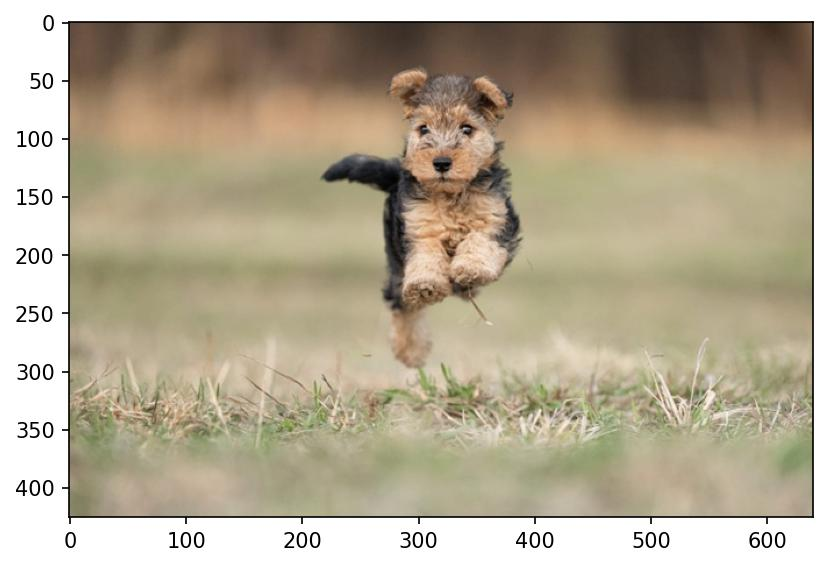

In [11]:
im = PIL.Image.open(ipnb_base + "картинка.jpg")
fig, ax = plt.subplots()
ax.imshow(im)
plt.show()

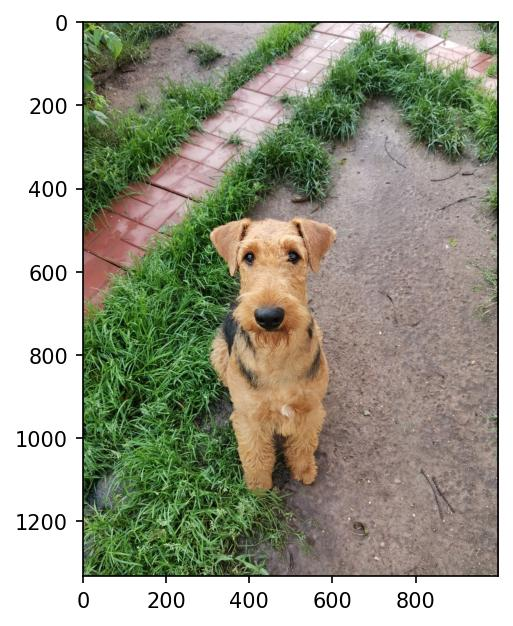

In [12]:
im1 = PIL.Image.open(ipnb_base + "картинка-1.png")
fig, ax = plt.subplots()
ax.imshow(im1)
plt.show()

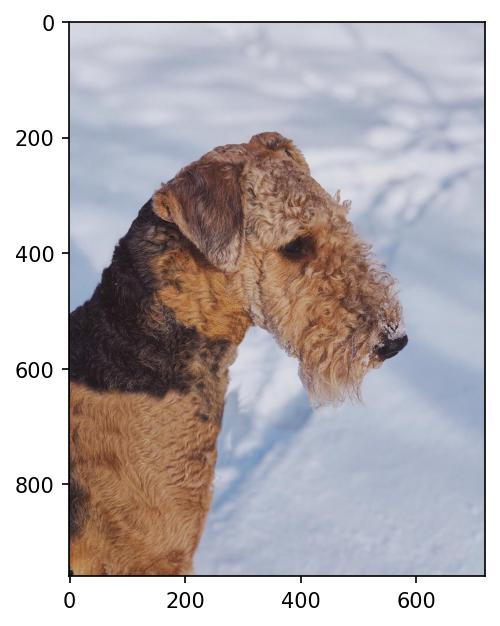

In [13]:
im2 = PIL.Image.open(ipnb_base + "картинка-2.tiff")
fig, ax = plt.subplots()
ax.imshow(im2)
plt.show()

### Проверка за видео ролик

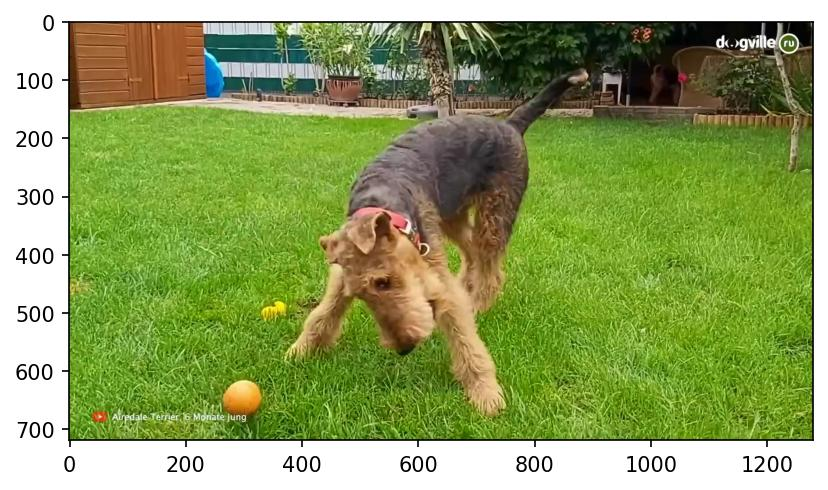

In [14]:
start_time = 2.*60. + 59.
cap = cv2.VideoCapture(ipnb_base + 'ролик.mp4')
frame_count = cap.get(cv2.CAP_PROP_FRAME_COUNT)
fps = cap.get(cv2.CAP_PROP_FPS)
start_frame_number = int(start_time*fps)
assert start_frame_number < frame_count
cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame_number)
ret, frame = cap.read()
assert ret
imv = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
fig, ax = plt.subplots()
ax.imshow(imv)
plt.show()

# Загрузка с Яндекс Диск

Здесь вариантов меньше, к тому же проблем с типом содержимого быть не
должно.

В описании [Яндекс Диск — REST API - Операции над опубликованными
файлами и папками](https://yandex.ru/dev/disk-api/doc/ru/reference/public)
написано, что OAuth-токен (и, соответственно, заголовок Authorization)
в таких запросах указывать не нужно.

Вариант, когда публикуется папка, а записка выбирает файлы из неё,
кажется более естественным, по крайней мере, нет необходимости
контроля имени файла.

In [15]:
yd_base_url = (
    "https://cloud-api.yandex.net/v1/disk/public/resources/download"
    "?public_key=")
yd_ipnb_dir = "tmp/yd/"
yd_dir = "https://disk.yandex.ru/d/Bl3EuzE67SmX6w"
yd_ipnb_depends = [
    (yd_dir, 'текстик.txt'),
    (yd_dir, 'картиночка-1.jpg'),
    (yd_dir, 'картиночка-2.png'),
    (yd_dir, 'фрагментик.mp4'),
]

def yd_fuh(depend):
    return (yd_ipnb_dir + depend[1],
            yd_base_url + depend[0] + "&path=/" + depend[1],
            {}, True)

def yd_get_download(response, headers):
    href = response['href']
    qsa = urllib.parse.parse_qsl(href, 
                       strict_parsing=True, 
                       errors='strict',
                       max_num_fields=20)
    return (href, dict(qsa)|dict(headers))

os.makedirs(yd_ipnb_dir, exist_ok=True)
yd_sync = aiohttp_sync(yd_ipnb_dir + 'yd',
                       yd_ipnb_depends, yd_fuh, yd_get_download,
                       timeout=0, verbose=2)
# yd_sync = requests_sync(yd_ipnb_dir + 'yd',
#                         yd_ipnb_depends, yd_fuh, yd_get_download,
#                         timeout=0, verbose=2)
crtn = yd_sync.sync()
if crtn:
    await crtn
print("Хорь")
# requests.Session() - 3.6 .. 6.7
# requests_sync() - 1.1 .. 2.8
# aiohttp_sync() - 0.7 .. 0.9

tmp/yd/картиночка-2.png - совпадает id
tmp/yd/фрагментик.mp4 - совпадает id
tmp/yd/картиночка-1.jpg - совпадает id
tmp/yd/текстик.txt - совпадает id
Синхронизация 0.73
Хорь


## Проверим, всё ли более менее?

Если загрузилось, то проблем быть не должно. Но загрузилось ли?

### Проверка за UTF-8 кодирование

In [16]:
with open(yd_ipnb_dir + "текстик.txt", encoding='utf-8') as fi:
    etext = fi.read()
    assert (etext.count('ё'), etext.count('Ё'), 
            etext.count('ё'), etext.count('Ё')) == (6, 1, 0, 0)
print("Хорь")

Хорь


### Проверка за картинки

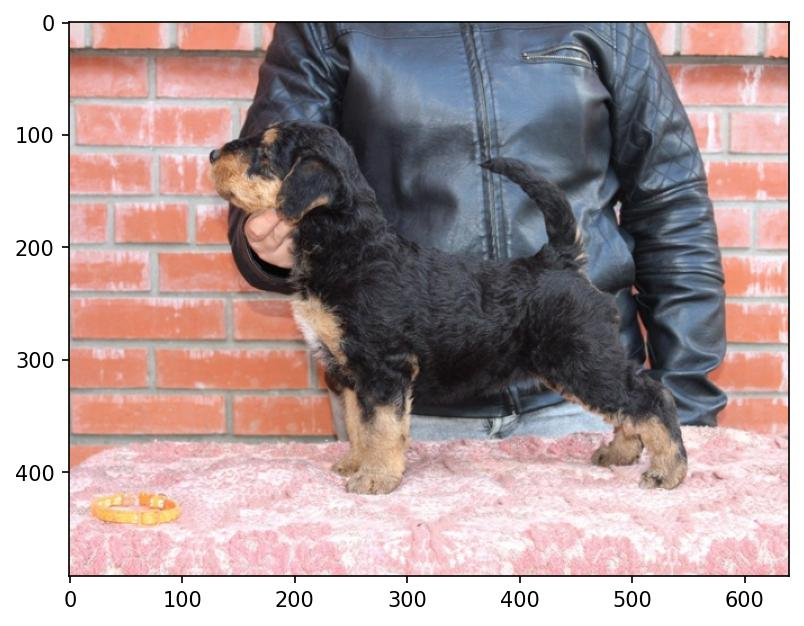

In [17]:
yim1 = PIL.Image.open(yd_ipnb_dir + "картиночка-1.jpg")
fig, ax = plt.subplots()
ax.imshow(yim1)
plt.show()

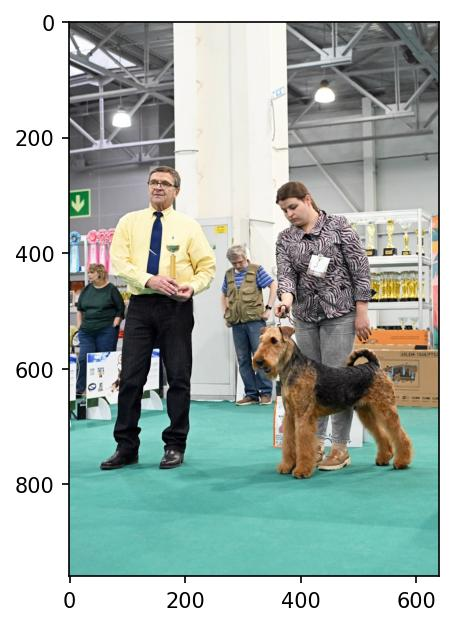

In [18]:
yim2 = PIL.Image.open(yd_ipnb_dir + "картиночка-2.png")
fig, ax = plt.subplots()
ax.imshow(yim2)
plt.show()

### Проверка за видео ролик

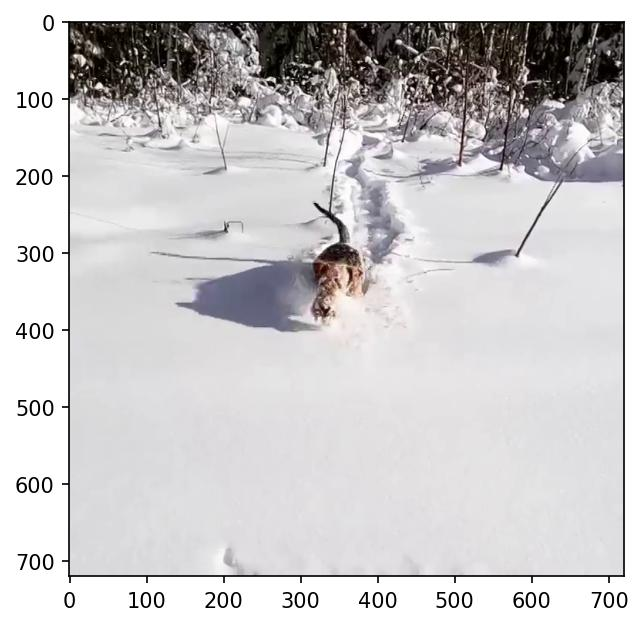

In [19]:
start_time = 2.
ycap = cv2.VideoCapture(yd_ipnb_dir + 'фрагментик.mp4')
frame_count = ycap.get(cv2.CAP_PROP_FRAME_COUNT)
fps = ycap.get(cv2.CAP_PROP_FPS)
start_frame_number = int(start_time*fps)
assert start_frame_number < frame_count
ycap.set(cv2.CAP_PROP_POS_FRAMES, start_frame_number)
ret, frame = ycap.read()
assert ret
yimv = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
fig, ax = plt.subplots()
ax.imshow(yimv)
plt.show()

# Сравнение

Синхронизация GitHub с LFS, вроде, рабочий вариант, конечно, при
умеренных файлах. Я точно не понял, но вроде бы в свободных планах
до 5 Гб. Кроме того, я ещё не понял, как контролировать объём.

Синхронизация с Яндекс Диск имеет тот минус, что синхронизировать
нужно всегда, а не только в Colab. Но из РФ, синхронизация весьма
шустра, опять же и процесс управления свободным местом понятен.